# Download of final data

The data set source is a pubblic collection of 1.7 billion reddit comments and posts loaded on BigQuery in this [link](https://console.cloud.google.com/bigquery?p=fh-bigquery%2F&project=reddit-254019&folder&organizationId)

After an inspection through the Bigquery's dataset in order to find the subreddit that have a good ratio of popularity and amount of data, I've ended up with 16 subreddit well distribuited along 16 differets catagories:


| Category                | Subreddit     |
| ----------------------- | ------------- |
| Sport                   | nba           |
| Video Games             | Games         |
| Technology              | technology    |
| News                    | worldnews     |
| Politic                 | politics      |
| Money                   | Frugal        |
| Discussion              | AskReddit     |
| Educational             | todayilearned |
| Movies                  | movies        |
| Religion                | atheism       |
| Cute                    | aww           |
| Health                  | Fitness       |
| Geography               | europe        |
| Science                 | science       |
| Books                   | books         |
| Food                    | food          |


The categories has been matched with a public classification of subreddit in GitHub: [subreddit-Directory-Skeleton](https://github.com/MetASnoo/Subreddit-Directory-Skeleton/blob/master/subreddits.txt)

### Visualization of the data

First of all we need the authentication:

In [26]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


and create the enviroment of my project:

In [3]:
%env GCLOUD_PROJECT=reddit-254019

env: GCLOUD_PROJECT=reddit-254019


Just to give a visualized idea of the data, the query below shows the comments' data with Data Studio where we can appreciate the growth of the fist 10 selected subreddits until 2018 (2019 is not complete so has been excluded from this representation):


In [25]:
%%bigquery --project reddit-254019
SELECT
  uniq_subreddit,
  number_comments,
  year,
  month
FROM
  `reddit-254019.reddit_comments.count_comments_allYears`
WHERE
  uniq_subreddit IN ('nba',
    'Games',
    'technology',
    'worldnews',
    'politics',
    'Frugal',
    'AskReddit',
    'todayilearned',
    'movies',
    'atheism') -- DataStudio shows only the first 10 elements
  AND year != 2019
ORDER BY
  year DESC

,uniq_subreddit,number_comments,year,month
0,AskReddit,6003147,2018,12
1,AskReddit,5834042,2018,10
2,AskReddit,5765531,2018,8
3,AskReddit,5652413,2018,7
4,AskReddit,5615448,2018,11
...,...,...,...,...
1277,atheism,6,2008,1
1278,movies,1,2008,1
1279,politics,57280,2007,10
1280,politics,35566,2007,9


In [28]:
from google.colab import files
uploaded = files.upload()

Saving final_subreddits_top_10.png to final_subreddits_top_10 (1).png


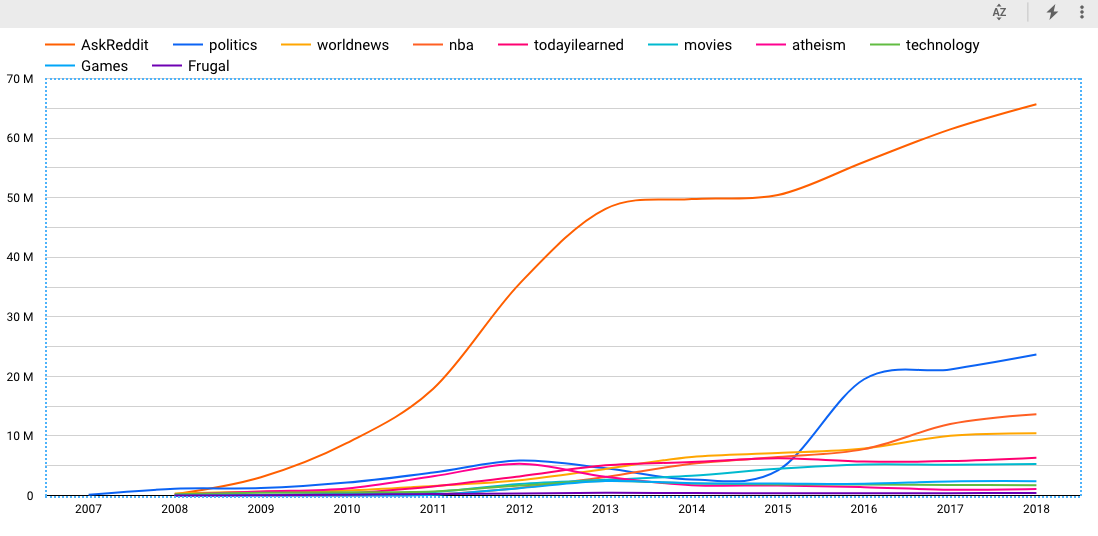

In [29]:
from IPython.display import Image
Image('final_subreddits_top_10 (1).png', width = 1000)

In [31]:
uploaded = files.upload()

Saving Info_final_subreddits_top_10.png to Info_final_subreddits_top_10 (1).png


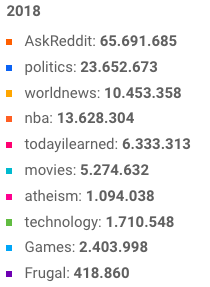

In [32]:
Image('Info_final_subreddits_top_10 (1).png', width = 200)

### Download of comments

I would like to download all comments from all years but my tools are limited so I've decided to look up the data from 2019 to be sure that there is enought information to work with:

In [35]:
%%bigquery --project reddit-254019
WITH
  q1 AS (
  SELECT
    subreddit,
    body,
    EXTRACT(month
    FROM
      TIMESTAMP_SECONDS(created_utc)) month
  FROM
    `fh-bigquery.reddit_comments.2019*`
  WHERE
    body != '[deleted]'
    AND body != '[removed]'
    AND body != '[ Removed by reddit in response to a copyright notice. ]'
    AND body != 'NaN'
    AND body != '' ),
  q2 AS(
  SELECT
    subreddit,
    body,
    month
  FROM
    q1
  WHERE
    subreddit IN ('nba',
      'Games',
      'technology',
      'worldnews',
      'politics',
      'Frugal',
      'AskReddit',
      'todayilearned',
      'movies',
      'atheism',
      'aww',
      'Fitness',
      'europe',
      'science',
      'books',
      'food')
    AND month IN (3,
      4,
      5))
SELECT
  DISTINCT(subreddit) AS uniq_subreddit,
  COUNT(body) AS count_body
FROM
  q2
GROUP BY
  1
ORDER BY
  2 DESC

,uniq_subreddit,count_body
0,AskReddit,20449496
1,politics,5259871
2,nba,4083627
3,worldnews,2662764
4,todayilearned,1622942
5,aww,1549115
6,movies,1412050
7,europe,630032
8,Games,591959
9,atheism,461280


**IMPORTANT**: this three months seems have enough information to train my model with the compromise of working with limited tools.




With the follow query I've downloaded all comments from 2019 of my top subreddits:

```
WITH
  q1 AS(
  SELECT
    subreddit,
    body,
    EXTRACT(month
    FROM
      TIMESTAMP_SECONDS(created_utc)) month
  FROM
    `fh-bigquery.reddit_comments.2019*`
  WHERE
    body != '[deleted]'
    AND body != '[removed]'
    AND body != '[ Removed by reddit in response to a copyright notice. ]'
    AND body != 'NaN'
    AND body != '' ),
  q2 AS(
  SELECT
    subreddit,
    body,
    month
  FROM
    q1
  WHERE
    subreddit IN ('nba',
      'Games',
      'technology',
      'worldnews',
      'politics',
      'Frugal',
      'AskReddit',
      'todayilearned',
      'movies',
      'atheism',
      'aww',
      'Fitness',
      'europe',
      'science',
      'books',
      'food')
    AND month IN (3,
      4,
      5))
SELECT
  subreddit,
  body
FROM
  q2

```

### Download of posts

As I did for comments, also posts will be downloeaded only from 2019, let's see if there is enought data:

In [36]:
%%bigquery --project reddit-254019
WITH
  q1 AS (
  SELECT
    subreddit,
    title,
    selftext,
    EXTRACT(month
    FROM
      TIMESTAMP_SECONDS(created_utc)) month
  FROM
    `fh-bigquery.reddit_posts.2019*`
  WHERE
    (LENGTH(title) > 5 AND LENGTH(selftext) > 5)
      or ((selftext != '[deleted]' AND length(title) > 5)
      AND (selftext != '[removed]' AND length(title) > 5)
      AND (selftext != '[ Removed by reddit in response to a copyright notice. ]' AND length(title) > 5)
      AND (selftext != 'NaN' AND length(title) > 5)
      AND (selftext != '' AND length(title) > 5))),
  q2 AS(
  SELECT
    subreddit,
    title,
    selftext,
    month
  FROM
    q1
  WHERE
    subreddit IN ('nba',
      'Games',
      'technology',
      'worldnews',
      'politics',
      'Frugal',
      'AskReddit',
      'todayilearned',
      'movies',
      'atheism',
      'aww',
      'Fitness',
      'europe',
      'science',
      'books',
      'food')
    AND month IN (3,
      4,
      5))
SELECT
  DISTINCT(subreddit) AS uniq_subreddit,
  COUNT(title) AS count_body
FROM
  q2
GROUP BY
  1
ORDER BY
  2 DESC

,uniq_subreddit,count_body
0,AskReddit,578516
1,nba,57139
2,aww,43825
3,movies,27489
4,Fitness,25187
5,politics,19704
6,todayilearned,11810
7,worldnews,11721
8,food,10968
9,atheism,10360


The data is enougth so we can go ahead with the next step, with the follow query I've downloaded all posts from 2019 of my top subreddits:

```
WITH
  q1 AS (
  SELECT
    subreddit,
    title,
    selftext,
    EXTRACT(month
    FROM
      TIMESTAMP_SECONDS(created_utc)) month
  FROM
    `fh-bigquery.reddit_posts.2019*`
  WHERE
    (LENGTH(title) > 5 AND LENGTH(selftext) > 5)
      or ((selftext != '[deleted]' AND length(title) > 5)
      AND (selftext != '[removed]' AND length(title) > 5)
      AND (selftext != '[ Removed by reddit in response to a copyright notice. ]' AND length(title) > 5)
      AND (selftext != 'NaN' AND length(title) > 5)
      AND (selftext != '' AND length(title) > 5))),
  q2 AS(
  SELECT
    subreddit,
    title,
    selftext,
    month
  FROM
    q1
  WHERE
    subreddit IN ('nba',
      'Games',
      'technology',
      'worldnews',
      'politics',
      'Frugal',
      'AskReddit',
      'todayilearned',
      'movies',
      'atheism',
      'aww',
      'Fitness',
      'europe',
      'science',
      'books',
      'food')
    AND month IN (3,
      4,
      5))
SELECT
  subreddit,
  title, 
  selftext
FROM
  q2
````

